In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

## 0. Getting Started

This demonstration uses 4 qubits to see how pre-training the quantum embedding can be helpful for training a parameterized QML circuits for classification tasks.

Load the dataset with four features

In [2]:
dev = qml.device('default.qubit', wires=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', '2', feature_reduction=feature_reduction, classes=classes)

def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)
    return torch.tensor(X1_new).to(device), torch.tensor(X2_new).to(device), torch.tensor(Y_new).to(device)

N_valid, N_test = 500, 10000
X1_new_valid, X2_new_valid, Y_new_valid = new_data(N_valid, X_test, Y_test)
X1_new_test, X2_new_test, Y_new_test = new_data(N_test, X_test, Y_test)

2022-12-14 06:07:59.815963: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 06:07:59.816649: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.
/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/torch/csrc/utils/tensor_new.cpp:233.)


Circuit for evaluating Model1_Fidelity and Model1_HSinner for 4 qubits

In [9]:
@qml.qnode(dev, interface="torch")
def Four_circuit(inputs): 
    embedding.Four_QuantumEmbedding(inputs[0:4])
    embedding.Four_QuantumEmbedding_inverse(inputs[4:8])
    return qml.probs(wires=range(4))

# 4 qubit Model1_Fidelity
class Four_Model1_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(Four_circuit, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]

# 4 qubit Model1_HSinner
class Four_Model1_HSinner(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.matrix_fn = qml.matrix(Four_circuit)
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1).to("cpu")
        x = [torch.real(torch.trace(self.matrix_fn(a))) for a in x]
        x = torch.stack(x, dim=0).to(device)
        return x / 2**8


In [10]:
def train_models(model_name):
    train_loss = []
    if model_name == 'Model1_Fidelity':
        model = Four_Model1_Fidelity().to(device)
        PATH = '/Users/tak/Github/QEmbedding/Results/4qubit_demonstration/Four_Model1_Fidelity.pt'
    elif model_name == 'Model1_HSinner':
        PATH = '/Users/tak/Github/QEmbedding/Results/4qubit_demonstration/Four_Model1_HSinner.pt'
        model = Four_Model1_HSinner().to(device)
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(1000):
        X1_batch, X2_batch, Y_batch = new_data(25, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch.to(device), X2_batch.to(device), Y_batch.to(device)

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 50 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)


#train_models('Model1_Fidelity')
train_models('Model1_HSinner')

Iterations: 0 Loss: 0.42405372858047485
Iterations: 50 Loss: 0.4098811447620392
Iterations: 100 Loss: 0.566443681716919
Iterations: 150 Loss: 0.4478074610233307
Iterations: 200 Loss: 0.620431125164032
Iterations: 250 Loss: 0.4321105480194092
Iterations: 300 Loss: 0.3962266445159912
Iterations: 350 Loss: 0.32625362277030945
Iterations: 400 Loss: 0.5811656713485718
Iterations: 450 Loss: 0.4308108985424042
Iterations: 500 Loss: 0.5085922479629517
Iterations: 550 Loss: 0.503308892250061
Iterations: 600 Loss: 0.46486178040504456
Iterations: 650 Loss: 0.5118796825408936
Iterations: 700 Loss: 0.46592777967453003
Iterations: 750 Loss: 0.3902164101600647
Iterations: 800 Loss: 0.4635812044143677
Iterations: 850 Loss: 0.2853042185306549
Iterations: 900 Loss: 0.46416279673576355
Iterations: 950 Loss: 0.35384780168533325


Calculate the distances of Test dataset with the pre-trained quantum embeddings. From the calculated trace distance gain the lower bound of the linear loss function (with respect to the test data).

In [12]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train), torch.tensor(X0_train)


@qml.qnode(dev, interface="torch")
def Four_Distance(inputs): 
    embedding.Four_QuantumEmbedding(inputs[0:4])
    return qml.density_matrix(wires=range(4))

class Distances(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1_distance = qml.qnn.TorchLayer(Four_Distance, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x0, Distance, Trained):
        if Trained:
            x1 = self.linear_relu_stack1(x1)
            x0 = self.linear_relu_stack1(x0)
        rhos1 = self.qlayer1_distance(x1)
        rhos0 = self.qlayer1_distance(x0)
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        if Distance == 'Trace':
            eigvals = torch.linalg.eigvals(rho_diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
        elif Distance == 'Hilbert-Schmidt':
            return 0.5 * torch.trace(rho_diff @ rho_diff)


PATH_Model1_Fidelity = '/Users/tak/Github/QEmbedding/Results/4qubit_demonstration/Four_Model1_Fidelity.pt'
PATH_Model1_HSinner = '/Users/tak/Github/QEmbedding/Results/4qubit_demonstration/Four_Model1_HSinner.pt'
Model1_Fidelity_Distance = Distances().to(device)
Model1_Fidelity_Distance.load_state_dict(torch.load(PATH_Model1_Fidelity, map_location=device))
Model1_HSinner_Distance = Distances().to(device)
Model1_HSinner_Distance.load_state_dict(torch.load(PATH_Model1_HSinner, map_location=device))

# Distances Before Training
Trace_before_traindata = Model1_Fidelity_Distance(X1_train, X0_train, 'Trace', False)
Trace_before_testdata = Model1_Fidelity_Distance(X1_test, X0_test, 'Trace', False)
print(f"Trace Distance (Training Data) Before: {Trace_before_traindata}")
print(f"Trace Distance (Test Data) Before: {Trace_before_testdata}")

# Distances After training with Model1_Fidelity
Trace_Fidelity_traindata = Model1_Fidelity_Distance(X1_train, X0_train, 'Trace', True)
Trace_Fidelity_testdata = Model1_Fidelity_Distance(X1_test, X0_test, 'Trace', True)
print(f"Trace Distance (Training Data) After Model1 Fidelity: {Trace_Fidelity_traindata}")
print(f"Trace Distance (Test Data) After Model1 Fidelity: {Trace_Fidelity_testdata}")

# Distances After training with Model1_HSinner
Trace_HSinner_traindata = Model1_HSinner_Distance(X1_train, X0_train, 'Trace', True)
Trace_HSinner_testdata = Model1_HSinner_Distance(X1_test, X0_test, 'Trace', True)
print(f"Trace Distance (Training Data) After Model1 HSinner: {Trace_HSinner_traindata}")
print(f"Trace Distance (Test Data) After Model1 HSinner: {Trace_HSinner_testdata}")

# Lower Bounds
LB_before_traindata = 0.5 * (1 - Trace_before_traindata.detach().numpy())
LB_Fidelity_traindata = 0.5 * (1 - Trace_Fidelity_traindata.detach().numpy())
LB_HSinner_traindata = 0.5 * (1 - Trace_HSinner_traindata.detach().numpy())

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Trace Distance (Training Data) Before: 0.2734867036342621
Trace Distance (Test Data) Before: 0.27234312891960144
Trace Distance (Training Data) After Model1 Fidelity: 0.9034680724143982
Trace Distance (Test Data) After Model1 Fidelity: 0.9114879369735718
Trace Distance (Training Data) After Model1 HSinner: 0.8135722279548645
Trace Distance (Test Data) After Model1 HSinner: 0.8203645944595337


## Training the parameterized QML circuit with pre-trained Qembedding

In [13]:
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [20]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()

model = x_transform().to(device)
model.load_state_dict(torch.load(PATH_Model1_Fidelity, map_location=device))
#model.load_state_dict(torch.load(PATH_Model1_HSinner, map_location=device))

<All keys matched successfully>

In [23]:
def statepreparation(x, Trained):
    if Trained:
        x = model(torch.tensor(x))
    embedding.Four_QuantumEmbedding(x)

def U(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

def QCNN_four(params):
    param1 = params[0:15]
    param2 = params[15:30]
    U(param1, wires=[0, 1])
    U(param1, wires=[2, 3])
    U(param1, wires=[1, 2])
    U(param1, wires=[3, 0])
    U(param2, wires=[0, 2])


@qml.qnode(dev)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    QCNN_four(params)
    return qml.expval(qml.PauliZ(2))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

steps = 1000
learning_rate = 0.01
batch_size = 128
def circuit_training(X_train, Y_train, Trained):

    weights = np.random.random(30, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 50 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history

In [24]:
Loss_histories_not_trained, Loss_histories_trained = [], []
for i in range(5):
    loss_not_trained = circuit_training(X_train, Y_train, False)
    loss_trained = circuit_training(X_train, Y_train, True)
    Loss_histories_not_trained.append(loss_not_trained)
    Loss_histories_trained.append(loss_trained)

Loss_histories_not_trained, Loss_histories_trained = np.array(Loss_histories_not_trained), np.array(Loss_histories_trained)
Not_trained_mean, Not_trained_std = Loss_histories_not_trained.mean(axis=0), Loss_histories_not_trained.std(axis=0)
Trained_mean, Trained_std = Loss_histories_trained.mean(axis=0), Loss_histories_trained.std(axis=0)

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.518763417837877
iteration:  50  cost:  0.436145380416376
iteration:  100  cost:  0.42875600679820147
iteration:  150  cost:  0.4413505988104019
iteration:  200  cost:  0.4007545804228994
iteration:  250  cost:  0.4100875132800625
iteration:  300  cost:  0.3866250233310193
iteration:  350  cost:  0.42328140330261316
iteration:  400  cost:  0.4233598119442521
iteration:  450  cost:  0.41384496269266213
iteration:  500  cost:  0.37237317144758997
iteration:  550  cost:  0.4160720318950565
iteration:  600  cost:  0.3477549918399355
iteration:  650  cost:  0.4119786475647613
iteration:  700  cost:  0.3540593856928393
iteration:  750  cost:  0.4172946154299804
iteration:  800  cost:  0.31722465912110265
iteration:  850  cost:  0.3901465770575886
iteration:  900  cost:  0.3837925402503268
iteration:  950  cost:  0.3322653986300494
iteration:  0  cost:  0.39052878687221576
iteration:  50  cost:  0.12007972702739236
iteration:  100  cost:  0.10450937286932402
iteration: 

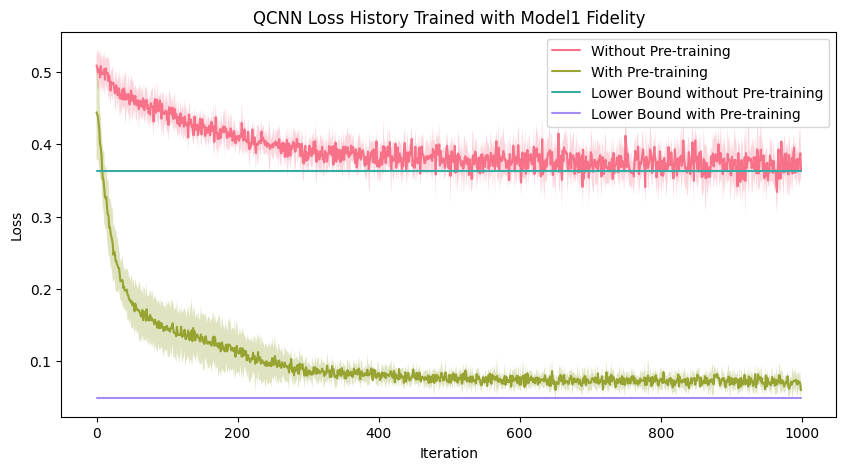

In [31]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 4)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(Not_trained_mean)), Not_trained_mean, label="Without Pre-training", c=clrs[0])
    ax.fill_between(range(len(Not_trained_mean)), Not_trained_mean-Not_trained_std, Not_trained_mean+Not_trained_std, alpha=0.3,facecolor=clrs[0])

    ax.plot(range(len(Trained_mean)), Trained_mean, label="With Pre-training", c=clrs[1])
    ax.fill_between(range(len(Trained_mean)), Trained_mean-Trained_std, Trained_mean+Trained_std, alpha=0.3,facecolor=clrs[1])

    ax.plot(range(1000), np.ones(1000) * LB_before_traindata, label="Lower Bound without Pre-training", c=clrs[2])
    ax.plot(range(1000), np.ones(1000) * LB_Fidelity_traindata, label="Lower Bound with Pre-training", c=clrs[3])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss History Trained with Model1 Fidelity")
ax.legend()


In [37]:
f = open('/Users/tak/Github/QEmbedding/Results/4qubit_demonstration/Loss_History_Model1_Fidelity.txt', 'w')

for i in range(5):
    f.write(f'Loss History Trained {i + 1}')
    f.write('\n')
    f.write(str(Loss_histories_trained[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Loss History Not Trained {i + 1}')
    f.write('\n')
    f.write(str(Loss_histories_not_trained[i]))
    f.write('\n')
f.close()

In [38]:
LB_before_traindata, LB_Fidelity_traindata

(0.36325664818286896, 0.0482659637928009)